In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
from datetime import datetime

# Vis. libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import altair as alt

# Time Series functions
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


&nbsp;
# Examine data


In [2]:
df = pd.read_excel('./TLODataSet012524.xlsx')

In [3]:
df['Date'] = df['Date'].apply(lambda x: datetime.date(x))
df['Time'] = df.apply(lambda row: datetime.combine(row['Date'], row['Start Time']), axis=1)
df.drop(columns=['Date', 'Start Time', 'Month', 'Day'], inplace=True)
df = df[['Time', 'Attendees']]
df.rename(columns={'Time':'time', 'Attendees':'attendees'}, inplace=True)
df.set_index('time', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2021-08-10 19:00:00 to 2024-03-26 19:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   attendees  131 non-null    int64
dtypes: int64(1)
memory usage: 2.0 KB


In [5]:
month_df = df.groupby(pd.Grouper(freq='MS')).agg(
    sum=('attendees', 'sum'),
    mean=('attendees', lambda x: (round(x.mean(), 2))),
    number_of_trainings=('attendees', 'count')
).reset_index() # Compare sum, mean for each month.
month_df

,time,sum,mean,number_of_trainings
0,2021-08-01,25,6.25,4
1,2021-09-01,43,14.33,3
2,2021-10-01,61,12.20,5
3,2021-11-01,47,15.67,3
4,2021-12-01,50,16.67,3
5,2022-01-01,27,6.75,4
6,2022-02-01,15,7.50,2
7,2022-03-01,35,17.50,2
8,2022-04-01,35,17.50,2
9,2022-05-01,26,13.00,2


In [6]:
alt.Chart(df.reset_index()).mark_line().encode(
    x='time', 
    y='attendees:Q'
).configure_axis(
    domainOpacity=0,
    grid=False,
    ticks=False
).configure_view(
    strokeWidth=0
).properties(
    width=800, 
    height=300,
    title="All trainings' attendees by day"
)

alt.Chart(...)

In [7]:
alt.Chart(month_df).mark_line().encode(
    x='time', 
    y='number_of_trainings:Q'
).configure_axis(
    domainOpacity=0,
    grid=False,
    ticks=False
).configure_view(
    strokeWidth=0
).properties(
    width=800, 
    height=300,
    title="Number of Trainings by Month"
)

alt.Chart(...)

In [8]:
rule = alt.Chart(month_df).transform_calculate(
    month="month(datum.time)"
).transform_filter(
    (alt.datum.month == 1) | (alt.datum.month == 7)
).mark_rule(
    color='#FF0000',
    strokeWidth=1,
    strokeDash=(4,4)
).encode(
    x='time:T',
)

sum_example = alt.Chart(
    month_df
).mark_line(color='green', width=3).encode(
    x=alt.X(
        'time:T',
        axis=alt.Axis(
            format=('%m'),
            title=None,
            tickCount=len(month_df),
        ),
    ), 
    y=alt.Y(
        'sum:Q',
        axis=alt.Axis(
            title='Number of Training Attendees',
            tickCount=5
        ),
        scale=alt.Scale(
            domain=[0,100]
        ),
    ),
    tooltip='sum'
).properties(
    width=800, 
    height=300,
    title="Sum of Attendees by Month"
)

mean_example = alt.Chart(
    month_df
).mark_line(color='green', width=3).encode(
    x=alt.X(
        'time:T',
        axis=alt.Axis(
            format=('%m'),
            title='Month',
            tickCount=len(month_df),
        ),
    ),
    y=alt.Y(
        'mean:Q',
        axis=alt.Axis(
            title='Number of Training Attendees',
            tickCount=5
        ),
        scale=alt.Scale(
            domain=[0, 20]
        )
    )
).properties(
    width=800, 
    height=300,
    title="Mean of Attendees by Month"
)

alt.vconcat(rule + sum_example, mean_example + rule, spacing=80).configure_axis(
    domainOpacity=0, 
    grid=False, 
    ticks=False
).configure_view(
    strokeWidth=0
)

alt.VConcatChart(...)


Choose **.mean()** over **.sum()** to penalize low-attendance trainings.

Seasonality seems to disappear in the mean.


In [9]:
# "Fall" months only (Aug., Sep., Oct., Nov., Dec., Jan.).
fall_df = df[(df.index.month >= 8) | (df.index.month <= 1)]
fall_df = fall_df.groupby(pd.Grouper(freq='m')).count() # The number of trainings.
fall_df = fall_df.loc[~(fall_df==0).all(axis=1)]
fall_df.rename(columns={'attendees':'trainings'})

,trainings
time,
2021-08-31,4
2021-09-30,3
2021-10-31,5
2021-11-30,3
2021-12-31,3
2022-01-31,4
2022-08-31,3
2022-09-30,6
2022-10-31,8


In [10]:
# For small groups (<=5 attendees), what do the trainings look like?
df[df['attendees'] <= 5]

,attendees
time,
2021-08-10 19:00:00,1
2022-01-11 18:00:00,0
2022-06-07 18:00:00,3
2022-06-27 18:00:00,1
2022-06-29 19:00:00,3
2022-07-06 20:00:00,4
2022-10-01 10:00:00,3
2022-10-24 18:00:00,5
2022-10-27 18:00:00,4


In [11]:
# What is the distribution of low-attendance trainings (<=5 attendees) by day of the week?
days_of_the_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
low_days = df[df['attendees'] <= 5].groupby(
    df[df['attendees'] <= 5].index.day_name()
).count().reindex(days_of_the_week).rename(columns={'attendees': 'trainings'})
low_days

,trainings
time,
Sunday,NaN
Monday,7.0
Tuesday,11.0
Wednesday,6.0
Thursday,7.0
Friday,5.0
Saturday,2.0


In [12]:
# How many trainings do we have overall for different days of the week?
training_days = df.groupby(
    df.index.day_name()
).count().reindex(days_of_the_week).rename(columns={'attendees': 'trainings'})
training_days

,trainings
time,
Sunday,1
Monday,19
Tuesday,33
Wednesday,19
Thursday,32
Friday,11
Saturday,16


In [13]:
round(low_days / training_days, 2).style.format('{:.0%}') # Normalize.

,trainings
time,
Sunday,nan%
Monday,37%
Tuesday,33%
Wednesday,32%
Thursday,22%
Friday,45%
Saturday,12%


In [14]:
# What is the average number of attendeees for a day of the week?
df.groupby(df.index.day_name()).mean().round(2).reindex(days_of_the_week)

,attendees
time,
Sunday,16.00
Monday,6.37
Tuesday,8.94
Wednesday,9.42
Thursday,10.34
Friday,7.64
Saturday,8.50


In [15]:
# At what hour are trainings held?

def convert_to_12h_time(day: str):
    return datetime.strptime(str(day), "%H").strftime("%I%p").lstrip("0")

training_hour_count = df.groupby(df.index.hour).count()
training_hour_count.index = training_hour_count.index.map(convert_to_12h_time)
training_hour_count

,attendees
time,
10AM,27
4PM,6
6PM,75
7PM,22
8PM,1


In [16]:
# Average attendees for hour of day (normalize by # of trainings).
training_hour_mean = df.groupby(df.index.hour).mean().round(2)
training_hour_mean.index = training_hour_mean.index.map(convert_to_12h_time)
training_hour_mean

,attendees
time,
10AM,8.15
4PM,4.33
6PM,9.25
7PM,9.91
8PM,4.00


[Text(50.72222222222221, 0.5, 'Day of the week')]

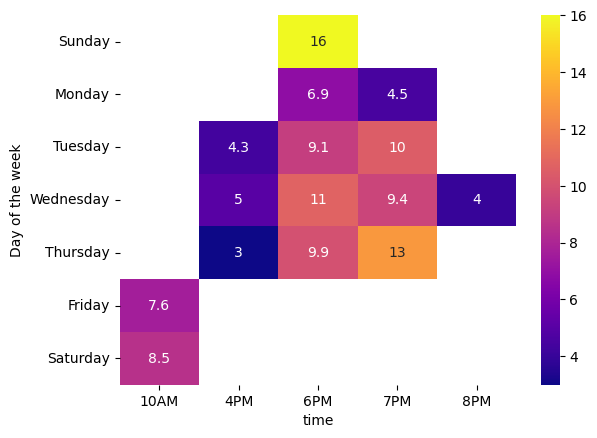

In [17]:
# Day + time combination heatmap (brighter is better).
ax = sns.heatmap(
    data=df.pivot_table(
        index=df.index.day_name(), 
        columns=df.index.hour, 
        values='attendees', 
        aggfunc='mean'
    ).reindex(days_of_the_week).rename(mapper=convert_to_12h_time, axis=1), 
    annot=True, 
    cmap='plasma'
)
ax.set(ylabel="Day of the week")

Text(0, 0.5, 'Trainings')

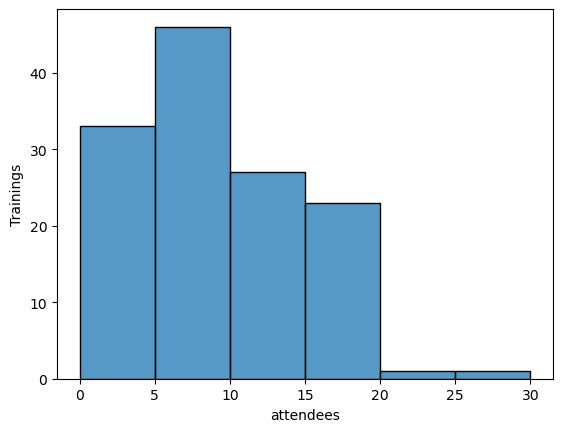

In [18]:
# Distribution of trainings by # of attendees.
sns.histplot(data=df, x='attendees', binwidth=5)
plt.ylabel('Trainings')


&nbsp;
## Time Series Analysis



Analyze the mean and variance to determine if our time series is stationary or non-stationary.


In [19]:
month_df = month_df.set_index('time')
month_df = month_df.asfreq('MS')

In [20]:
def rolling_mean_and_std(series, wd_size=7):
    rolling_mean = np.array(series.rolling(wd_size, min_periods=1).apply(lambda x: np.average(x)))
    rolling_std = np.array(series.rolling(wd_size, min_periods=1).apply(lambda x: np.std(x)))
    
    return rolling_mean, rolling_std

In [21]:
rolling_mean_and_std(month_df['mean'], wd_size=3)

(array([ 6.25      , 10.29      , 10.92666667, 14.06666667, 14.84666667,
        13.03      , 10.30666667, 10.58333333, 14.16666667, 16.        ,
        11.75      ,  8.08333333,  6.75      ,  9.05666667,  9.72333333,
         9.93      ,  7.70666667,  8.60666667,  7.62333333,  8.84666667,
         7.44666667,  7.22333333,  7.16666667, 10.16666667, 11.83333333,
        12.94333333, 11.07      ,  9.73666667,  6.96      ,  5.27666667,
         4.27666667,  3.64333333]),
 array([0.        , 4.04      , 3.41932092, 1.42880681, 1.91548659,
        4.4593572 , 4.50996181, 4.90039681, 4.71404521, 2.12132034,
        5.27967802, 3.54925657, 1.74403746, 2.11102397, 1.39155389,
        1.31258016, 1.96776241, 2.63060618, 2.61936803, 1.85357912,
        0.87545544, 1.10140315, 1.02740233, 4.24918293, 3.11804782,
        2.18778935, 0.59402581, 2.0236326 , 2.80889065, 1.4293666 ,
        0.77228377, 1.54350971]))

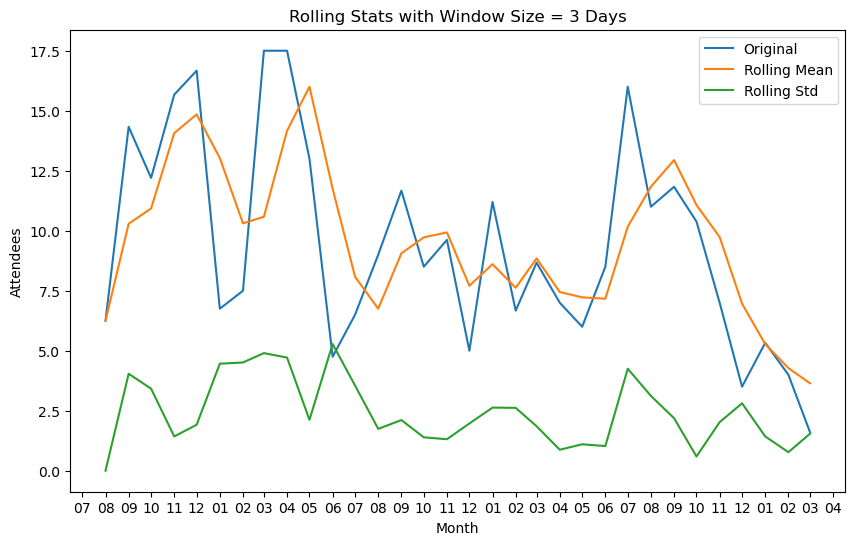

In [32]:
series, wd_size = month_df['mean'], 3
rolling_mean, rolling_std = rolling_mean_and_std(series, wd_size)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(series, label="Original")
ax.plot(pd.Series(rolling_mean, index=series.index), label="Rolling Mean")
ax.plot(pd.Series(rolling_std, index=series.index), label="Rolling Std")

ax.set_xlabel("Month")
ax.set_ylabel("Attendees")
ax.set_title(f"Rolling Stats with Window Size = {wd_size} Days")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.legend()


The seasonal component of this time series data makes the time series non-stationary; therefore, we should seek to convert the time series to a stationary one.


In [46]:
# Check Augmented Dickey-Fuller p-value < 0.05 for stationary time series.
_, pval, *_ = adfuller(month_df['mean'])
print(f"p-value: {round(pval, 3)}")

p-value: 0.026


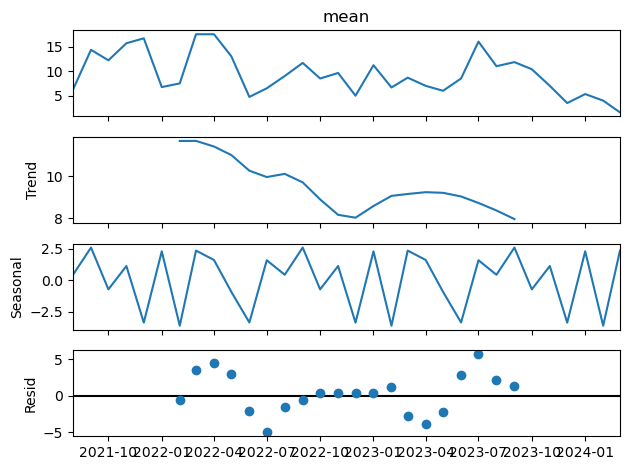

In [47]:
decomposed = seasonal_decompose(month_df['mean'])
decomposed.plot()
plt.show()


Dickey-Fuller p-value appears fine (<0.05), but seasonal_decompose() still shows some seasonality in the data and residuals.


Text(0, 0.5, 'Correlation')

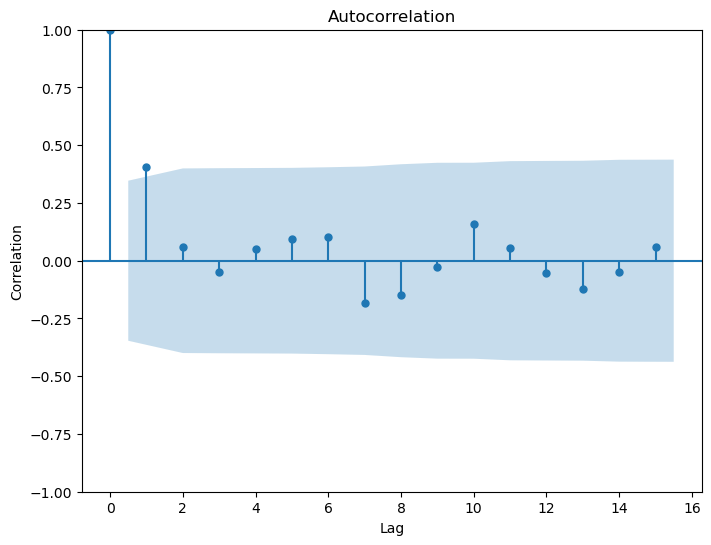

In [25]:
# Plot the ACF - find q. Where is the lag statistically significant from 0? (outside blue CI boundary)
series, max_lag = month_df['mean'], 15
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(series, ax, lags=max_lag)
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

Text(0, 0.5, 'Correlation')

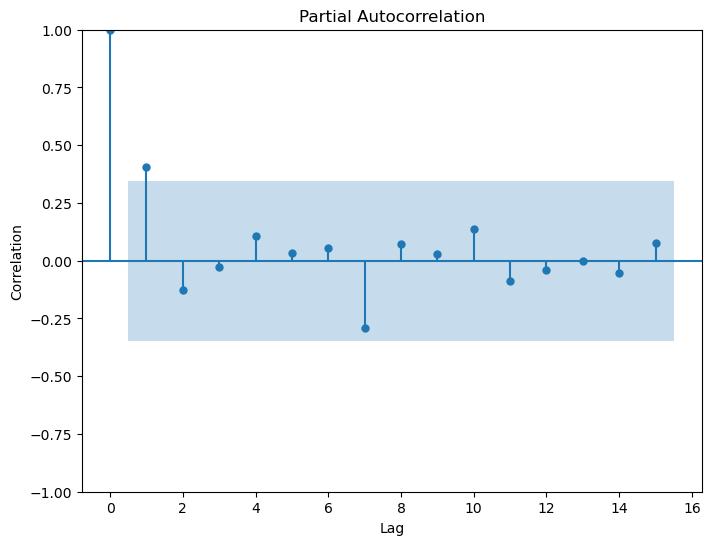

In [26]:
# Plot the PACF - find p. Where is the lag statistically significant from 0? (outside blue CI boundary)
series, max_lag = month_df['mean'], 15
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(series, ax, lags=max_lag)
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")


## ARIMA


In [55]:
def arima_forecast(series, p, d, q, num_forecasts):
    forecasts = None
    
    model = ARIMA(series, order=(p, d, q))
    model_fit = model.fit()

    f_dates = [series.index[-1] + DateOffset(months=x) for x in range(0, num_forecasts)]
    f_series = pd.Series(index=f_dates[1:])
    f_series = pd.concat([series, f_series])
    
    forecasts = model_fit.forecast(num_forecasts)
    
    return forecasts

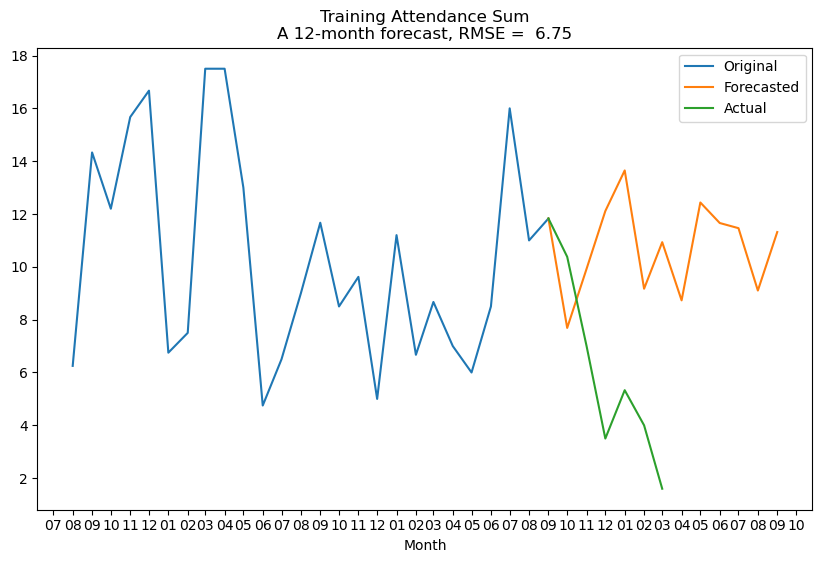

In [56]:
series = month_df['mean'][:-6]
p, d, q, num_forecasts = 7, 1, 1, 12 # Experiment with different values of p, q.

forecasts = arima_forecast(series, p, d, q, num_forecasts)
actual = month_df['mean'][-6:]
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(series, label="Original")
ax.plot(pd.concat([series[-1:], forecasts]), label="Forecasted")
ax.plot(pd.concat([series[-1:], actual]), label="Actual")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.set_xlabel("Month")
ax.set_title("Training Attendance Sum\n" + f"A {len(forecasts)}-month forecast, RMSE = {rmse: .2f}")
ax.legend()


See if grid search hyperparameters yields better ARIMA model.



## SARIMA


In [52]:
def sarima_forecast(series, P, D, Q, s, num_forecasts):
    model = SARIMAX(
        series, 
        order=(1, 0, 0), 
        seasonal_order=(P, D, Q, s),
        # trend='c'
    )
    model_fit = model.fit()

    f_dates = [series.index[-1] + DateOffset(months=x) for x in range(0, num_forecasts)]
    f_series = pd.Series(index=f_dates[1:])
    f_series = pd.concat([series, f_series])
    
    forecasts = model_fit.forecast(num_forecasts)
    
    return forecasts

/home/rj/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83193D+00    |proj g|=  3.48202D-01

At iterate    5    f=  2.53691D+00    |proj g|=  1.63938D-01

At iterate   10    f=  2.26044D+00    |proj g|=  3.53844D-01

At iterate   15    f=  2.20419D+00    |proj g|=  2.24513D-01

At iterate   20    f=  2.19831D+00    |proj g|=  1.71107D-02

At iterate   25    f=  2.19534D+00    |proj g|=  2.27609D-02

At iterate   30    f=  2.19419D+00    |proj g|=  2.56565D-02

At iterate   35    f=  2.19316D+00    |proj g|=  1.01732D-02

At iterate   40    f=  2.19276D+00    |proj g|=  6.95237D-03

At iterate   45    f=  2.19263D+00    |proj g|=  8.10166D-03

At iterate   50    f=  2.19261D+00    |proj g|=  2.88504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/rj/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


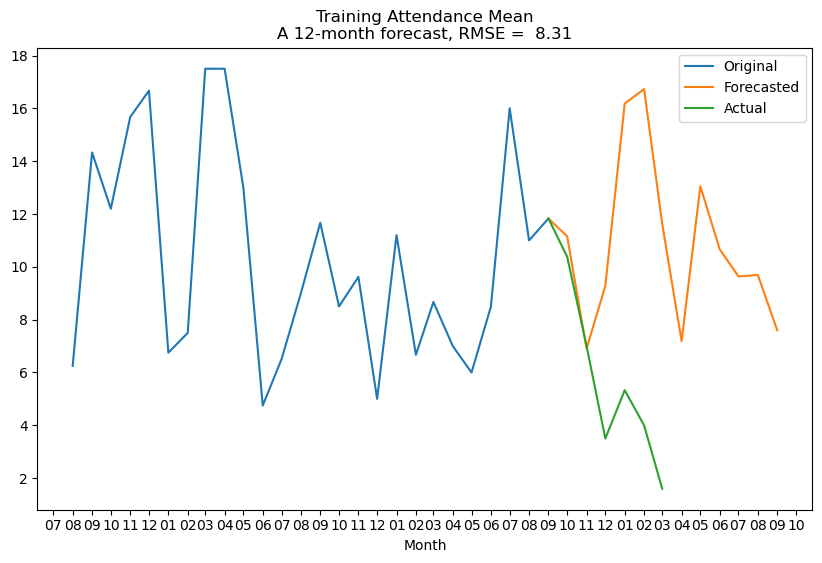

In [53]:
series = month_df['mean'][:-6]
P, D, Q, s, num_forecasts = 9, 1, 1, 2, 12

forecasts = sarima_forecast(series, P, D, Q, s, num_forecasts)
actual = month_df['mean'][-6:]
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(series, label="Original")
ax.plot(pd.concat([series[-1:], forecasts]), label="Forecasted")
ax.plot(pd.concat([series[-1:], actual]), label="Actual")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax.set_xlabel("Month")
ax.set_title("Training Attendance Mean\n" + f"A {len(forecasts)}-month forecast, RMSE = {rmse: .2f}")
ax.legend()


Given the remaining seasonality within the data, SARIMA yields a more consistent-looking prediction vs. ARIMA, despite SARIMA RMSE of 8.31 vs. ARIMA RMSE of 6.75.
